<a href="https://colab.research.google.com/github/intimanjunath/Decision-trees-and-ensemble/blob/main/AdaBoost_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [12]:
#This class implements the basic weak learner used in AdaBoost. It determines a single best feature and threshold to split the data.

In [20]:
class DecisionStump:
    def __init__(self):
        self.feature_idx = None
        self.threshold = None
        self.polarity = 1

    def fit(self, X, y, weights):
        n_samples, n_features = X.shape
        min_error = float("inf")

        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]
            thresholds = np.unique(feature_values)

            for threshold in thresholds:
                for polarity in [1, -1]:
                    y_pred = np.ones(n_samples)
                    if polarity == 1:
                        y_pred[feature_values < threshold] = -1
                    else:
                        y_pred[feature_values >= threshold] = -1

                    error = np.sum(weights[y != y_pred])

                    if error < min_error:
                        min_error = error
                        self.feature_idx = feature_idx
                        self.threshold = threshold
                        self.polarity = polarity

    def predict(self, X):
        n_samples = X.shape[0]
        y_pred = np.ones(n_samples)
        if self.polarity == 1:
            y_pred[X[:, self.feature_idx] < self.threshold] = -1
        else:
            y_pred[X[:, self.feature_idx] >= self.threshold] = -1
        return y_pred

In [21]:
class AdaBoost:
    def __init__(self, base_estimator, n_estimators=50, learning_rate=1.0):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        self.alpha = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        weights = np.full(n_samples, (1 / n_samples))

        for _ in range(self.n_estimators):
            stump = DecisionStump()
            stump.fit(X, y, weights)
            predictions = stump.predict(X)

            error = np.sum(weights[y != predictions]) / np.sum(weights)

            # Compute alpha (importance of weak learner)
            alpha = self.learning_rate * 0.5 * np.log((1 - error) / max(error, 1e-10))
            self.alpha.append(alpha)
            self.models.append(stump)

            # Update weights
            weights = weights * np.exp(-alpha * y * predictions)
            weights /= np.sum(weights)

    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])
        for alpha, model in zip(self.alpha, self.models):
            predictions = model.predict(X)
            final_predictions += alpha * predictions
        return np.sign(final_predictions)

In [15]:
#Load the Pima Indians Diabetes Dataset

In [22]:
# Load dataset
cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
        "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
url = "https://gist.githubusercontent.com/ktisha/c21e73a1bd1700294ef790c56c8aec1f/raw/819b69b5736821ccee93d05b51de0510bea00294/pima-indians-diabetes.csv"
diabetes_data = pd.read_csv(url, skiprows=9, header=None, names=cols)

# Split into features and labels
X = diabetes_data[cols[:-1]].values
y = diabetes_data[cols[-1]].values

# Convert labels to -1 and 1 for AdaBoost
y = np.where(y == 0, -1, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [23]:
# Initialize AdaBoost with Decision Stumps
ada_clf = AdaBoost(base_estimator=DecisionStump(), n_estimators=50, learning_rate=1.0)

# Train the model
ada_clf.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)

# Evaluate accuracy
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Validation Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")

Training Accuracy: 0.83
Validation Accuracy: 0.73


Precision: 0.62
Recall: 0.57
F1-Score: 0.60


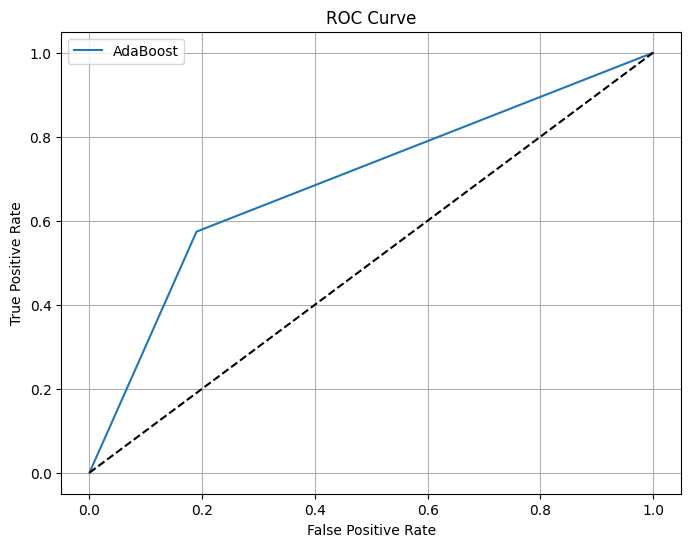

AUC Score: 0.69


In [24]:
# Metrics
print(f"Precision: {precision_score(y_test, y_test_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.2f}")

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="AdaBoost")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# AUC Score
auc = roc_auc_score(y_test, y_test_pred)
print(f"AUC Score: {auc:.2f}")